### 0. 코랩 환경 설정

In [ ]:
!pip install numpy==1.24.4 --quiet
!pip install gym==0.26.2 --upgrade --quiet


### 1. DQN 구현

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque  # 고정 크기 버퍼 구현에 사용

# Q-Network 정의: 상태(state)를 입력받아 각 행동(action)에 대한 Q값 출력하는 신경망
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # 2개의 fully connected layer로 구성
        self.layers = nn.Sequential(
            nn.Linear(state_dim, 128),  # 입력층(state_dim) → 은닉층(128 유닛)
            nn.ReLU(),                  # 활성화 함수 ReLU
            nn.Linear(128, action_dim)  # 은닉층 → 출력층(action_dim), 각 행동별 Q값 출력
        )

    def forward(self, x):
        # 네트워크의 순전파(포워드) 함수: 입력 x에 대해 Q값 출력
        return self.layers(x)


# DQN 에이전트 클래스
class DQNAgent:
    def __init__(self,
                 state_dim,         # 상태 공간 차원 (예: CartPole은 4)
                 action_dim,        # 행동 공간 크기 (예: CartPole은 2)
                 gamma=0.99,        # 할인율, 미래 보상에 대한 현재 가치 반영 비율
                 lr=1e-3,           # 학습률
                 batch_size=32,     # 학습 미니배치 크기
                 buffer_size=10000, # 경험 리플레이 버퍼 최대 크기
                 epsilon=1.0,       # 탐험 확률 초기값 (epsilon-greedy 정책)
                 epsilon_min=0.01,  # epsilon의 최소값 (더 이상 줄이지 않음)
                 epsilon_decay=0.999, # epsilon 감소 비율 (에피소드 혹은 스텝마다 감소)
                 target_update_freq=10,  # 타겟 네트워크 업데이트 주기(몇 번 학습 후 업데이트)
                 device='cpu'):     # 연산 디바이스 설정(cpu 또는 cuda)

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.lr = lr
        self.batch_size = batch_size

        # 고정 크기 큐 형태의 경험 리플레이 버퍼
        self.buffer = deque(maxlen=buffer_size)

        # epsilon-greedy 정책 관련 변수
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.device = device

        # Q-Network 및 타겟 네트워크 초기화 (동일 구조, 다른 가중치)
        self.q_net = QNetwork(state_dim, action_dim).to(device)
        self.target_q_net = QNetwork(state_dim, action_dim).to(device)
        self.target_q_net.load_state_dict(self.q_net.state_dict())  # 초기 가중치 동기화

        # 옵티마이저: Adam, 손실 함수: MSELoss
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()

        # 학습 중 손실 기록용 리스트
        self.loss_history = []

        # 타겟 네트워크 업데이트 주기 및 카운터 초기화
        self.target_update_freq = target_update_freq
        self.update_count = 0

    def get_action(self, state, epsilon=None):
        """
        현재 상태에 대해 행동 선택 (epsilon-greedy)
        - epsilon 확률로 랜덤 행동 (탐험)
        - 1 - epsilon 확률로 Q-Network가 예측한 최적 행동 (이용)
        """
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.rand() < epsilon:
            return np.random.randint(self.action_dim)  # 랜덤 행동
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # 배치 차원 추가
            q_values = self.q_net(state)  # Q값 예측
            return torch.argmax(q_values, dim=1).item()  # 최대 Q값 행동 반환

    def update(self):
        """
        Q-Network 학습 수행
        - 버퍼에서 미니배치 샘플링
        - 벨만 최적 방정식에 따른 타겟 Q값 계산
        - MSE Loss 계산 및 역전파
        - 타겟 네트워크를 일정 주기마다 업데이트
        - epsilon 감소
        """
        if len(self.buffer) < self.batch_size:
            return  # 버퍼 부족 시 학습 중지

        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # numpy 배열 → 텐서 변환 및 장치 이동
        states = torch.FloatTensor(np.vstack(states)).to(self.device)
        next_states = torch.FloatTensor(np.vstack(next_states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # 현재 상태-행동 쌍의 Q값
        q_values = self.q_net(states).gather(1, actions)
        # 다음 상태에서 최대 Q값 (타겟 네트워크 사용, 그래디언트 차단)
        next_q_values = self.target_q_net(next_states).max(dim=1, keepdim=True)[0].detach()
        # 타겟 Q값 계산 (종료 상태면 보상만, 아니면 보상+감가된 미래 최대 Q값)
        target = rewards + (1 - dones) * self.gamma * next_q_values

        # 손실 계산 및 기록
        loss = self.loss_fn(q_values, target)
        self.loss_history.append(loss.item())

        # 역전파 및 가중치 업데이트
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 학습 횟수 증가 및 타겟 네트워크 업데이트 조건 검사
        self.update_count += 1
        if self.update_count % self.target_update_freq == 0:
            self.update_target()

        # epsilon 점진적 감소
        self.decay_epsilon()

    def remember(self, state, action, reward, next_state, done):
        """
        경험 리플레이 버퍼에 transition 저장
        - state, next_state는 numpy float32 배열로 저장하여 일관성 유지
        """
        self.buffer.append((
            np.array(state, dtype=np.float32),
            action,
            reward,
            np.array(next_state, dtype=np.float32),
            done
        ))

    def update_target(self):
        """
        타겟 네트워크를 현재 Q-Network 가중치로 동기화
        """
        self.target_q_net.load_state_dict(self.q_net.state_dict())

    def decay_epsilon(self):
        """
        epsilon 값을 점진적으로 감소시키되, epsilon_min 이하로는 내려가지 않음
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


### 2. 학습이 되는가

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[Episode 1] Reward: 14.0, Epsilon: 1.000
[Episode 2] Reward: 28.0, Epsilon: 0.989
[Episode 3] Reward: 23.0, Epsilon: 0.967
[Episode 4] Reward: 21.0, Epsilon: 0.946
[Episode 5] Reward: 19.0, Epsilon: 0.929
[Episode 6] Reward: 31.0, Epsilon: 0.900
[Episode 7] Reward: 15.0, Epsilon: 0.887
[Episode 8] Reward: 27.0, Epsilon: 0.863
[Episode 9] Reward: 14.0, Epsilon: 0.851
[Episode 10] Reward: 18.0, Epsilon: 0.836
[Episode 11] Reward: 14.0, Epsilon: 0.824
[Episode 12] Reward: 18.0, Epsilon: 0.810
[Episode 13] Reward: 15.0, Epsilon: 0.798
[Episode 14] Reward: 20.0, Epsilon: 0.782
[Episode 15] Reward: 18.0, Epsilon: 0.768
[Episode 16] Reward: 10.0, Epsilon: 0.760
[Episode 17] Reward: 11.0, Epsilon: 0.752
[Episode 18] Reward: 12.0, Epsilon: 0.743
[Episode 19] Reward: 49.0, Epsilon: 0.707
[Episode 20] Reward: 13.0, Epsilon: 0.698
[Episode 21] Reward: 12.0, Epsilon: 0.690
[Episode 22] Reward: 14.0, Epsilon: 0.680
[Episode 23] Reward: 15.0, Epsilon: 0.670
[Episode 24] Reward: 15.0, Epsilon: 0.660
[

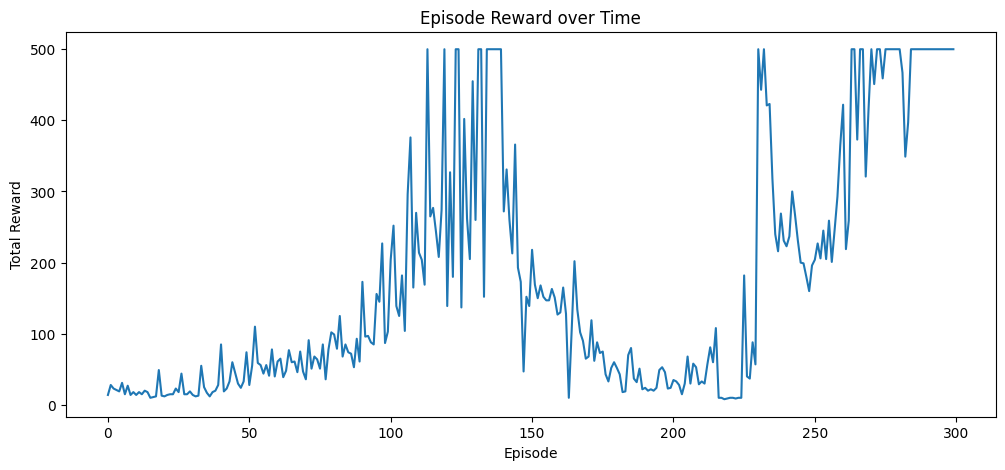

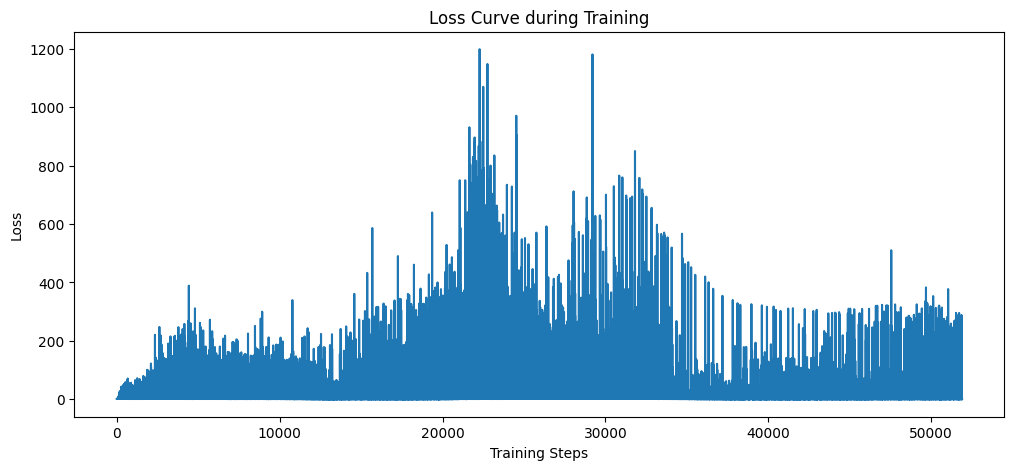

In [ ]:
import gym
import matplotlib.pyplot as plt

# 환경 및 Agent 초기화
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
device = 'cuda' if torch.cuda.is_available() else 'cpu'

agent = DQNAgent(state_dim, action_dim, device=device)

episodes = 300
episode_rewards = []

for ep in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        agent.remember(state, action, reward, next_state, done)
        agent.update()

        state = next_state
        total_reward += reward

    episode_rewards.append(total_reward)
    print(f"[Episode {ep+1}] Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

# 에피소드별 누적 보상 그래프
plt.figure(figsize=(12,5))
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episode Reward over Time')
plt.show()

# 학습 손실 그래프
plt.figure(figsize=(12,5))
plt.plot(agent.loss_history)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Loss Curve during Training')
plt.show()

### 3. 테스트시 엡실론 0으로

In [ ]:
import gym

env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim)

episodes = 100
for ep in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        # 테스트 시에는 epsilon=0 주어서 탐험 없이 행동 선택
        action = agent.get_action(state, epsilon=0)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # 학습 중이 아니면 버퍼에 저장 안 함, update도 안 함
        # 만약 학습도 하려면 epsilon=agent.epsilon 으로 호출
        state = next_state
        total_reward += reward

    print(f"[Test Episode {ep+1}] Total Reward: {total_reward}")


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[Test Episode 1] Total Reward: 36.0
[Test Episode 2] Total Reward: 21.0
[Test Episode 3] Total Reward: 29.0
[Test Episode 4] Total Reward: 24.0
[Test Episode 5] Total Reward: 38.0
[Test Episode 6] Total Reward: 35.0
[Test Episode 7] Total Reward: 26.0
[Test Episode 8] Total Reward: 30.0
[Test Episode 9] Total Reward: 30.0
[Test Episode 10] Total Reward: 33.0
[Test Episode 11] Total Reward: 32.0
[Test Episode 12] Total Reward: 34.0
[Test Episode 13] Total Reward: 38.0
[Test Episode 14] Total Reward: 33.0
[Test Episode 15] Total Reward: 31.0
[Test Episode 16] Total Reward: 24.0
[Test Episode 17] Total Reward: 26.0
[Test Episode 18] Total Reward: 22.0
[Test Episode 19] Total Reward: 33.0
[Test Episode 20] Total Reward: 24.0
[Test Episode 21] Total Reward: 32.0
[Test Episode 22] Total Reward: 30.0
[Test Episode 23] Total Reward: 21.0
[Test Episode 24] Total Reward: 34.0
[Test Episode 25] Total Reward: 25.0
[Test Episode 26] Total Reward: 36.0
[Test Episode 27] Total Reward: 30.0
[Test Epis

### 4. action 디버깅

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque  # 고정 크기 버퍼 구현에 사용

# Q-Network 정의: 상태 입력 -> 행동별 Q값 출력 신경망
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.layers(x)


class DQNAgent:
    def __init__(self,
                 state_dim,
                 action_dim,
                 gamma=0.99,
                 lr=1e-3,
                 batch_size=32,
                 buffer_size=10000,
                 epsilon=1.0,
                 epsilon_min=0.01,
                 epsilon_decay=0.995,
                 target_update_freq=10,  # 타겟 네트워크 업데이트 주기 (스텝 단위)
                 device='cpu'):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.lr = lr
        self.batch_size = batch_size

        self.buffer = deque(maxlen=buffer_size)

        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.device = device

        self.q_net = QNetwork(state_dim, action_dim).to(device)
        self.target_q_net = QNetwork(state_dim, action_dim).to(device)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()

        self.loss_history = []

        self.target_update_freq = target_update_freq
        self.update_count = 0

    def get_action(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.rand() < epsilon:
            return np.random.randint(self.action_dim)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_net(state)
            return torch.argmax(q_values, dim=1).item()

    def update(self):
        if len(self.buffer) < self.batch_size:
            return

        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.vstack(states)).to(self.device)
        next_states = torch.FloatTensor(np.vstack(next_states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        next_q_values = self.target_q_net(next_states).max(dim=1, keepdim=True)[0].detach()
        target = rewards + (1 - dones) * self.gamma * next_q_values

        loss = self.loss_fn(q_values, target)
        self.loss_history.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_count += 1
        if self.update_count % self.target_update_freq == 0:
            self.update_target()

        self.decay_epsilon()

    def remember(self, state, action, reward, next_state, done):
        self.buffer.append((
            np.array(state, dtype=np.float32),
            action,
            reward,
            np.array(next_state, dtype=np.float32),
            done
        ))

    def update_target(self):
        self.target_q_net.load_state_dict(self.q_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    # ------------------- 디버깅용 함수 추가 -------------------

    # 상태 하나 넣었을 때 Q값, 선택된 action, gather 값 출력
    def debug_action_values(self, state):
        self.q_net.eval()
        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            else:
                state_tensor = state.unsqueeze(0).to(self.device)

            q_values = self.q_net(state_tensor)  # (1, action_dim)
            print("Q values for all actions:", q_values.cpu().numpy())

            action = torch.argmax(q_values, dim=1)
            print("Chosen action index:", action.item())

            gathered_q = q_values.gather(1, action.unsqueeze(1))
            print("Gathered Q-value for chosen action:", gathered_q.item())
        self.q_net.train()

    # update 중 batch 샘플링 상태에서 gather 동작 디버깅
    def debug_update_batch(self):
        if len(self.buffer) < self.batch_size:
            print("Not enough samples in buffer for debugging update batch.")
            return

        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.vstack(states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        q_values = self.q_net(states)
        gathered_q = q_values.gather(1, actions)

        print("States batch shape:", states.shape)
        print("Actions batch shape:", actions.shape)
        print("Q-values shape:", q_values.shape)
        print("Gathered Q-values shape:", gathered_q.shape)
        print("Sample gathered Q-values:", gathered_q[:5].detach().cpu().numpy())



In [ ]:
import gym
import numpy as np

env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, target_update_freq=10)

episodes = 5
for ep in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    print(f"Episode {ep+1} 시작")

    while not done:
        # 디버깅용 Q값 출력 및 선택된 액션 확인
        agent.debug_action_values(state)

        action = agent.get_action(state)  # 행동 선택
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # 경험 저장 및 학습 업데이트
        agent.remember(state, action, reward, next_state, done)
        agent.update()

        state = next_state
        total_reward += reward

    print(f"Episode {ep+1} 종료, 총 보상: {total_reward}, epsilon: {agent.epsilon:.3f}")

    # 디버깅용 batch 업데이트 gather 값 확인
    agent.debug_update_batch()

env.close()


Episode 1 시작
Q values for all actions: [[ 0.09052394 -0.02445206]]
Chosen action index: 0
Gathered Q-value for chosen action: 0.09052394330501556
Q values for all actions: [[0.05740868 0.02197242]]
Chosen action index: 0
Gathered Q-value for chosen action: 0.05740867927670479
Q values for all actions: [[0.01250139 0.05664952]]
Chosen action index: 1
Gathered Q-value for chosen action: 0.05664951726794243
Q values for all actions: [[0.05654727 0.02575355]]
Chosen action index: 0
Gathered Q-value for chosen action: 0.056547265499830246
Q values for all actions: [[ 0.09119439 -0.01773352]]
Chosen action index: 0
Gathered Q-value for chosen action: 0.09119439125061035
Q values for all actions: [[0.0563318  0.02779796]]
Chosen action index: 0
Gathered Q-value for chosen action: 0.056331802159547806
Q values for all actions: [[ 0.09036893 -0.01470873]]
Chosen action index: 0
Gathered Q-value for chosen action: 0.09036892652511597
Q values for all actions: [[ 0.12141374 -0.05467036]]
Chosen a

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Q values for all actions: [[2.0839577 2.095814 ]]
Chosen action index: 1
Gathered Q-value for chosen action: 2.0958139896392822
Q values for all actions: [[2.464667  2.5143285]]
Chosen action index: 1
Gathered Q-value for chosen action: 2.5143284797668457
Q values for all actions: [[2.250679  2.2507071]]
Chosen action index: 1
Gathered Q-value for chosen action: 2.2507071495056152
Q values for all actions: [[2.0451267 2.0019958]]
Chosen action index: 0
Gathered Q-value for chosen action: 2.0451266765594482
Q values for all actions: [[2.4537537 2.4364676]]
Chosen action index: 0
Gathered Q-value for chosen action: 2.453753709793091
Q values for all actions: [[2.8977463 2.8972561]]
Chosen action index: 0
Gathered Q-value for chosen action: 2.8977463245391846
Episode 5 종료, 총 보상: 14.0, epsilon: 0.711
States batch shape: torch.Size([32, 4])
Actions batch shape: torch.Size([32, 1])
Q-values shape: torch.Size([32, 2])
Gathered Q-values shape: torch.Size([32, 1])
Sample gathered Q-values: [[2.